In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Импортируем необходимые библиотеки для обучения:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # библиотека для визуализации статистических данных

# Указать путь размещения файлов main_task.csv, kaggle_task.csv, sample_submission.csv
data_path = 'Data/'

df_train=pd.read_csv(data_path+'main_task.csv')
df_test=pd.read_csv(data_path+'kaggle_task.csv')
sample_submission = pd.read_csv(data_path+'sample_submission.csv')

In [2]:
# зафиксируем RANDOM_SEED для воспроизводимости
RANDOM_SEED = 42

## Data analysis:

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [6]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [8]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [9]:
# Для корректной (единой) обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['Rating'] = 0 # в тесте нет значения Rating - предсказывается, поэтому заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [10]:
rating = pd.DataFrame(df_train['Rating'] + df_test['Rating'], columns = ['Rating']).fillna(0)
rating

,Rating
0,3.5
1,4.0
2,4.5
3,5.0
4,4.0
...,...
39995,0.0
39996,0.0
39997,0.0
39998,0.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


**Подробнее по признакам:**

- City: Город  
- Cuisine Style: Кухня  
- Ranking: Ранг ресторана относительно других ресторанов в этом городе  
- Price Range: Цены в ресторане в 3 категориях  
- Number of Reviews: Количество отзывов  
- Reviews: 2 последних отзыва и даты этих отзывов  
- URL_TA: страница ресторана на 'www.tripadvisor.com'  
- ID_TA: ID ресторана в TripAdvisor  
- Rating: Рейтинг ресторана  

In [12]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
32693,id_1112,Oslo,"['Chinese', 'Japanese', 'Sushi', 'Thai']",1115.0,NaN,3.0,"[['Great sushi!', 'Budget sushi of ok quality,...",/Restaurant_Review-g190479-d6019894-Reviews-Ha...,d6019894,1,2.5
3888,id_3888,Vienna,NaN,2406.0,NaN,4.0,"[[], []]",/Restaurant_Review-g190454-d10525289-Reviews-C...,d10525289,0,0.0
14682,id_2216,London,"['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...",2221.0,$$ - $$$,174.0,"[['Amazing food', 'Wonderful place and food'],...",/Restaurant_Review-g186338-d11180601-Reviews-B...,d11180601,1,4.5
15117,id_2117,Prague,NaN,2121.0,NaN,4.0,"[['This place is fantastic!', 'Little gem off ...",/Restaurant_Review-g274707-d12445889-Reviews-C...,d12445889,1,4.5
21463,id_4798,Milan,"['Chinese', 'Japanese', 'Sushi', 'Asian', 'Fus...",4801.0,$,64.0,"[['Good price, good food', 'Good sushi,long li...",/Restaurant_Review-g187849-d9563519-Reviews-As...,d9563519,1,3.5


In [13]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

## 1. Обработка NaN

Отсутствие информации может быть важным признаком, поэтому перед обработкой NAN лучше вынести информацию о наличии пропуска, как отдельный признак

### 1.1. Столбец 'Number of Reviews'

In [14]:
# Выносим информацию о наличии пропуска, как отдельный признак
data['Numb_of_Rev_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [15]:
len(data[data['Numb_of_Rev_isNAN'] == 0])

46800

In [16]:
len(data[data['Numb_of_Rev_isNAN'] == 1])

3200

In [17]:
# Заполняем пропуски средним по городу
rew_mean = np.round(data.groupby(by = 'City')['Number of Reviews'].mean(),0)
for city in data.City.unique():
    data.loc[(data['City'] == city)&(data['Numb_of_Rev_isNAN']==1),['Number of Reviews']] = rew_mean[city]

### 1.2. Столбец 'Cuisine Style'

In [18]:
# Выносим информацию о наличии пропуска, как отдельный признак
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [19]:
len(data[data['Cuisine_Style_isNAN'] == 0])

38410

In [20]:
len(data[data['Cuisine_Style_isNAN'] == 1])
# np.sum(data['Cuisine Style'].isnull())

11590

In [21]:
# Приводим к единому стилю в столбце - NaN заполняем "['Some']", для последующей единой обработки столбца
data['Cuisine Style'].fillna("['Some']", inplace = True, axis = 0)

In [22]:
type(data['Cuisine Style'][0])

str

In [23]:
# Функция для иного заполнения (возможно в некоторых случаях этот способ будет лучше)  
#def fill_na_list(item, str_title = 'Some'):  
#    if type(item) == float:  
#        return str([str_title])  
#    else:  
#        return item  
#data['Cuisine Style'] = data['Cuisine Style'].apply(fill_na_list)  


#data.head(10)

### 1.3. Столбец 'Price Range'

In [24]:
# Выносим информацию о наличии пропуска, как отдельный признак
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [25]:
len(data[data['Price_Range_isNAN'] == 0])

32639

In [26]:
len(data[data['Price_Range_isNAN'] == 1])

17361

In [27]:
# Делаем столбец по ценовым диапазонам
def price_range(price):
    if type(price) == float: # если NaN, то считаем, что диапазон отдельный
        return 1
    elif price == '$':
        return 2
    elif price == '$$ - $$$':
        return 3
    elif price == '$$$$':
        return 4
data['Price Range'] = data['Price Range'].apply(price_range)

### 1.4. Столбец 'Reviews'

In [28]:
# Так как в столбце всего 2 NaN, то просто можно удалить эти строки (1 строка в train, 1 строка в test),  
# а можно заполнить ненулевыми, но пустыми данными:
def temp_func(rew):
    if type(rew) == float:
        return 0
    else:
        return len(rew)
# Смотрим данные с ненулевыми, но пустыми отзывами - есть только символы без букв '[[], []]'
data[data['Reviews'].apply(temp_func) < 10].head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,3,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0
6,id_6,Lisbon,"['European', 'Portuguese']",3704.0,2,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,0.0,0,0,0
7,id_7,Budapest,['Some'],2330.0,1,159.0,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,1,1,1
18,id_18,Vienna,['Some'],3360.0,1,2.0,"[[], []]",/Restaurant_Review-g190454-d8435085-Reviews-An...,d8435085,0,0.0,0,1,1
20,id_20,Barcelona,['Some'],6085.0,1,8.0,"[[], []]",/Restaurant_Review-g187497-d8334752-Reviews-Re...,d8334752,0,0.0,0,1,1


In [29]:
# Таких строк с отсутствующими отзывами '[[], []]' - 8112: 
data[data['Reviews'].apply(temp_func) < 10]['Reviews'].count()

8112

In [30]:
# Заполняем строки с NaN данными '[[], []]'
data['Reviews'].fillna(data['Reviews'][0], inplace = True, axis = 0)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant_id        50000 non-null  object 
 1   City                 50000 non-null  object 
 2   Cuisine Style        50000 non-null  object 
 3   Ranking              50000 non-null  float64
 4   Price Range          50000 non-null  int64  
 5   Number of Reviews    50000 non-null  float64
 6   Reviews              50000 non-null  object 
 7   URL_TA               50000 non-null  object 
 8   ID_TA                50000 non-null  object 
 9   sample               50000 non-null  int64  
 10  Rating               50000 non-null  float64
 11  Numb_of_Rev_isNAN    50000 non-null  uint8  
 12  Cuisine_Style_isNAN  50000 non-null  uint8  
 13  Price_Range_isNAN    50000 non-null  uint8  
dtypes: float64(3), int64(2), object(6), uint8(3)
memory usage: 4.3+ MB


### 1.5. Итого - заменили все строки с NaN данными.

## 2. Feature engineering

### 2.1 Cuisine numb

In [32]:
# Делаем столбец количества разных кухонь
def cuisine_num(cuisine_srting):
    cui_list = []
    if type(cuisine_srting) == float: # если NaN, то считаем, что кухня одна
        return 1
    elif ', ' in cuisine_srting:
        for item in list(cuisine_srting[1:-1].split(', ')):
            cui_list.append(item[1:-1])
        return len(cui_list)
    else:
        cui_list.append(cuisine_srting[2:-2])
        return len(cui_list)
data['Cuisine_numb'] = data['Cuisine Style'].apply(cuisine_num)

### 2.2 Strange numb

In [33]:
# В столбце URL_TA есть 2 числа, котоые можно попробовать использовать в качестве фич
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

In [34]:
# Создаем функции для выбора данных чисел из строки
def strange_numb_1(url_str):
    pattern = re.compile('d\d+')
    numb = int(pattern.findall(url_str)[0][1:])
    return numb 
    
def strange_numb_2(url_str):
    pattern = re.compile('g\d+')
    numb = int(pattern.findall(url_str)[0][1:])
    return numb     
#strange_numb_1('/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html')

In [35]:
data['URL_numb_1'] = data['URL_TA'].apply(strange_numb_1)
data['URL_numb_2'] = data['URL_TA'].apply(strange_numb_2)

In [36]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Cuisine_numb,URL_numb_1,URL_numb_2
0,id_0,Paris,"['Bar', 'Pub']",12963.0,3,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,2,10746918,187147
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,3,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,5,6674944,189934
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,3,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,1,13129638,186525
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,4,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0,5,680417,186338
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,4,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0,6,1112354,274924


### 2.3 Days between the last comments

In [37]:
# Делаем расчет количества дней между комментариями (даты содержатся в столбце Reviews)
def max_delta_days(data_str):
    pattern = re.compile('\d\d\W\d\d\W\d\d\d\d') #паттерн для даты формата xx/xx/xxxx, xx.xx.xxxx
        
    list_dates = pattern.findall(data_str) # создаем лист выбранных дат
    
    if len(list_dates) == 0 or len(list_dates) == 1: # Если дат нет или одна - возвращаем 0
        return 0 
    else:
        max_diff = 0
        for i in range(0, len(list_dates)-1): # в данном случае создана функция для случая, если дат больше 2-х
            if '.' in list_dates[i]: # для формата dd.mm.yyyy 
                date_dt_1 = datetime.strptime(list_dates[i], '%d.%m.%Y')
            elif '/' in list_dates[i]: 
                date_dt_1 = datetime.strptime(list_dates[i], '%m/%d/%Y')
            for j in range(1, len(list_dates)):
                if '.' in list_dates[j]: # для формата dd.mm.yyyy 
                    date_dt_2 = datetime.strptime(list_dates[j], '%d.%m.%Y')
                elif '/' in list_dates[j]: 
                    date_dt_2 = datetime.strptime(list_dates[j], '%m/%d/%Y')
                delta = abs(date_dt_1 - date_dt_2)
                if delta.days > max_diff:
                    max_diff = delta.days
        return max_diff

data['max_day_rev'] = data['Reviews'].apply(max_delta_days)

In [38]:
# Заменяем данные без комментариев (где выше был получен 0) максимальным числом + 1 день  
# Предположение: считаем, что, если даты наиболее близки, значит ресторан может получить большую оценку
data.loc[data['max_day_rev'] == 0, ['max_day_rev']] = data['max_day_rev'].max() + 1
# data.head()

### 2.4 Days to now

In [39]:
## Создаем функцию для определения даты от последнего комментария до текущей даты

In [40]:
# Смотрим поздний комментарий
def temp_max_data(data_str):
    pattern = re.compile('\d\d\W\d\d\W\d\d\d\d') #паттерн для даты формата xx/xx/xxxx, xx.xx.xxxx
    list_dates = pattern.findall(data_str) # создаем лист выбранных дат
    if len(list_dates) == 0: 
        return datetime.strptime('01/01/1000', '%m/%d/%Y') 
        
    else:
        date_list = []
        for i in range(0, len(list_dates)):
            if '.' in list_dates[i]: # для формата dd.mm.yyyy 
                date_dt = datetime.strptime(list_dates[i], '%d.%m.%Y')
            elif '/' in list_dates[i]: 
                date_dt = datetime.strptime(list_dates[i], '%m/%d/%Y')
            date_list.append(date_dt)
        return np.max(date_list)

data['Reviews'].apply(temp_max_data).max()

datetime.datetime(2018, 2, 26, 0, 0)

In [41]:
# Смотрим ранний комментарий
def temp_min_data(data_str):
    pattern = re.compile('\d\d\W\d\d\W\d\d\d\d') #паттерн для даты формата xx/xx/xxxx, xx.xx.xxxx
    list_dates = pattern.findall(data_str) # создаем лист выбранных дат
    if len(list_dates) == 0: 
        return datetime.strptime('01/01/2020', '%m/%d/%Y') 
        
    else:
        date_list = []
        for i in range(0, len(list_dates)):
            if '.' in list_dates[i]: # для формата dd.mm.yyyy 
                date_dt = datetime.strptime(list_dates[i], '%d.%m.%Y')
            elif '/' in list_dates[i]: 
                date_dt = datetime.strptime(list_dates[i], '%m/%d/%Y')
            date_list.append(date_dt)
        return np.min(date_list)

data['Reviews'].apply(temp_min_data).min()

Timestamp('2004-04-21 00:00:00')

In [42]:
# функция для определения даты от последнего комментария до текущей даты
def days_to_now(data_str):
    pattern = re.compile('\d\d\W\d\d\W\d\d\d\d') #паттерн для даты формата xx/xx/xxxx, xx.xx.xxxx
    max_date = datetime.strptime('04/20/2004', '%m/%d/%Y') # ставим на 1 день раньше, чем самая ранняя дата
    date_today = datetime.strptime('09/01/2020', '%m/%d/%Y')
    list_dates = pattern.findall(data_str) # создаем лист выбранных дат
    
    if len(list_dates) == 0: 
        delta = (date_today - max_date) 
        
    else:
        for i in range(0, len(list_dates)):
            if '.' in list_dates[i]: # для формата dd.mm.yyyy 
                date_dt = datetime.strptime(list_dates[i], '%d.%m.%Y')
            elif '/' in list_dates[i]: 
                date_dt = datetime.strptime(list_dates[i], '%m/%d/%Y')
            if date_dt > max_date:
                max_date = date_dt
        delta = (date_today - max_date)
    return delta.days

data['days_to_now'] = data['Reviews'].apply(days_to_now)

In [43]:
data.head() # смотрим промежуточный получившийся датасет

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Cuisine_numb,URL_numb_1,URL_numb_2,max_day_rev,days_to_now
0,id_0,Paris,"['Bar', 'Pub']",12963.0,3,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,2,10746918,187147,3297,5978
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,3,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,5,6674944,189934,37,1001
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,3,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,1,13129638,186525,22,978
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,4,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0,5,680417,186338,14,1000
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,4,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0,6,1112354,274924,15,936


### 2.5 Доп данные - из отчета Demographia World Urban Areas 15 th Annual Edition: 201904

In [44]:
data['City'].unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

In [45]:
# Население городов из отчета
city_population_dict ={'Paris':10960000, 'Stockholm':1585000, 'London':10840000, 'Berlin':4060000, 
                       'Munich':2060000, 'Oporto':1480000, 'Milan':5295000, 'Bratislava':410000, 
                       'Vienna':1850000, 'Rome':3995000, 'Barcelona':4810000, 'Madrid':6345000, 
                       'Dublin':1215000, 'Brussels':2135000, 'Zurich':805000, 'Warsaw':2300000, 
                       'Budapest':2520000, 'Copenhagen':1310000, 'Amsterdam':1670000, 'Lyon':1680000, 
                       'Hamburg':2050000, 'Lisbon':2705000, 'Prague':1375000, 'Oslo':1020000, 
                       'Helsinki':1270000, 'Edinburgh':525000, 'Geneva':620000, 'Ljubljana':225000, 
                       'Athens':3495000, 'Luxembourg':100000, 'Krakow':760000}

In [46]:
# Площадь городов из отчета
city_area_dict ={'Paris':2845, 'Stockholm':414, 'London':1738, 'Berlin':1347, 
                 'Munich':466, 'Oporto':777, 'Milan':15001891, 'Bratislava':119, 
                 'Vienna':337, 'Rome':1114, 'Barcelona':1075, 'Madrid':1360, 
                 'Dublin':318, 'Brussels':803, 'Zurich':246, 'Warsaw':544, 
                 'Budapest':971, 'Copenhagen':616, 'Amsterdam':505, 'Lyon':1178, 
                 'Hamburg':777, 'Lisbon':958, 'Prague':298, 'Oslo':290, 
                 'Helsinki':641, 'Edinburgh':120, 'Geneva':181, 'Ljubljana':54, 
                 'Athens':583, 'Luxembourg':62, 'Krakow':220}

In [47]:
def population(city_name):
    return city_population_dict[city_name]

In [48]:
def area(city_name):
    return city_area_dict[city_name]

In [49]:
data['Population'] = data['City'].apply(population)
data['Area'] = data['City'].apply(area)
#data.head()

### Примечание: Для автоматизации процесса - доработать cпособ извлечения информации из PDF отчета

### 2.6 One hot encoding City

In [50]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

### 2.7 One hot encoding Cuisine Style

In [51]:
# One hot encoding для столбца, содержащего листы данных (Найдено на просторах интернета)  
# Сильно увеличивает количество параметров, но точность повышается не сильно  
# data = pd.concat([data, pd.get_dummies(data['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)], axis=1)  
# The logicпризнака of this is:  
#.apply(Series) converts the series of lists to a dataframe  
#.stack() puts everything in one column again (creating a multi-level index)  
# pd.get_dummies( ) creating the dummies  
#.sum(level=0) for remerging the different rows that should be one row (by summing up the second level, only keeping the original level (level=0))  

In [52]:
#data.head()

### 2.8 Parsing tripavisor analisys - см. Файл Parsing_Data_from_Tripadvisor.ipynb
Парсинг данных проводим в файле Parsing_Data_from_Tripadvisor (имеется смещение данных - в анализируемом файле, уже не актуальные данные, тогда как на сайте данные постоянно обновляются)
Что можно сделать: 
1. обновить данные до 2020 года в анализируемых данных;
2. взять расстояния от ресторана до достопримечательности или центра города;
3. взять число загруженных фотографий;
4. использование данных по питанию, обслуживанию, цена/качество, атмосфера, считаю, что брать не корректно, так как это фактически добавление информации о рейтинге: похоже, что рейтинг - среднее арифметическое от указанных данных.
5. получение данных о наличии / отсутствии "награды Travellers' Choice".
6. получение данных о наличии / отсутствии собственного сайта.
7. возможно время работы будет также полезно.
8. получение данных о времени приема пищи - завтрак обед и ужин, например, не везде бывает завтрак;
9. получение данных о наличии / отсутствии меню.  

**Важно!!! Парсить придется 50000 страниц с периодическим возможным запретом сервера на подключение. Лучше сразу выбрать все необходимые данные или выбрать их по максимуму, с сохранением в файл и последующей обработкой**.

### 2.9 PolynomialFeatures

In [53]:
from sklearn.preprocessing import PolynomialFeatures

In [54]:
pf = PolynomialFeatures(4)

In [55]:
data.columns

Index(['Restaurant_id', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'Numb_of_Rev_isNAN', 'Cuisine_Style_isNAN', 'Price_Range_isNAN',
       'Cuisine_numb', 'URL_numb_1', 'URL_numb_2', 'max_day_rev',
       'days_to_now', 'Population', 'Area', 'City_Amsterdam', 'City_Athens',
       'City_Barcelona', 'City_Berlin', 'City_Bratislava', 'City_Brussels',
       'City_Budapest', 'City_Copenhagen', 'City_Dublin', 'City_Edinburgh',
       'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow',
       'City_Lisbon', 'City_Ljubljana', 'City_London', 'City_Luxembourg',
       'City_Lyon', 'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto',
       'City_Oslo', 'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm',
       'City_Vienna', 'City_Warsaw', 'City_Zurich', 'City_nan'],
      dtype='object')

In [56]:
col_with_numbs = ['Ranking', 'Number of Reviews', 'URL_numb_1', 'URL_numb_2', 'max_day_rev', 'days_to_now', 
           'Population', 'Area', 'Cuisine_numb']
poly_features_list = []
ind = 0
for poly_1 in col_with_numbs[:-1]:
    for poly_2 in col_with_numbs[col_with_numbs.index(poly_1) + 1 : ]:
        ind += 1
        poly_features = pf.fit_transform(data[[poly_1, poly_2]])[:, 3:]
        poly_features_list.append(pd.DataFrame(
            poly_features, columns = ['poly_feat_' + str(ind) + '_' + str(x) for x in range(poly_features.shape[1])]))
print(len(poly_features_list[0]), len(poly_features_list))

50000 36


In [57]:
data = data.join([poly_features for poly_features in poly_features_list])

In [58]:
poly_feat_ind = list(data.columns[list(data.columns).index('poly_feat_1_0'):])
col_with_numbs += poly_feat_ind

### Примечание: Что еще можно сделать для генерирования фич: можно использовать полиномиальные признаки: деление старых (полученных) признаков друг на друга + можно брать корень. 

## 3.0 Exploratory Data Analysis  - доработать для получения новых фичей

#### Посмотрим распределение признака

Много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

Посмотрим, как изменится распределение в большом городе:

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого имеем смещение.

### Примечание для доработки: из этого можно сделать признак для модели. 

#### Посмотрим распределение целевой переменной

#### Посмотрим распределение целевой переменной относительно признака

In [59]:
for col in data.columns:
    if data[col].dtype == object:
        data.drop([col], inplace = True, axis = 1)

In [60]:
# Нормализация данных в столбцах с большими числами:
data_to_std = data[col_with_numbs]

data = data.drop(col_with_numbs, axis=1)

data_to_std = pd.DataFrame(data=StandardScaler().fit_transform(data_to_std), columns=data_to_std.columns)

data = data.join(data_to_std) # объединяем
data.head()

,Price Range,sample,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,poly_feat_36_2,poly_feat_36_3,poly_feat_36_4,poly_feat_36_5,poly_feat_36_6,poly_feat_36_7,poly_feat_36_8,poly_feat_36_9,poly_feat_36_10,poly_feat_36_11
0,3,0,0.0,0,0,0,0,0,0,0,...,-0.464456,-0.238639,-0.188564,-0.132409,-0.411072,-0.238639,-0.188564,-0.132419,-0.099020,-0.235263
1,3,0,0.0,0,0,0,0,0,0,0,...,1.103814,-0.238639,-0.188564,-0.132330,0.728160,-0.238639,-0.188564,-0.132419,-0.098876,0.299862
2,3,0,0.0,0,0,0,0,0,0,0,...,-0.688495,-0.238639,-0.188564,-0.132601,-0.479232,-0.238639,-0.188564,-0.132419,-0.099076,-0.248443
3,4,0,0.0,0,0,0,0,0,0,0,...,1.103814,-0.238639,-0.188564,-0.131864,0.728160,-0.238639,-0.188564,-0.132419,-0.098534,0.299862
4,4,0,0.0,0,0,0,0,0,0,0,...,1.925289,-0.238639,-0.188564,-0.132530,1.614230,-0.238639,-0.188564,-0.132419,-0.099012,0.889465


In [61]:
# Выделим тестовую часть 
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [62]:
train_data.head()

,Price Range,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,poly_feat_36_2,poly_feat_36_3,poly_feat_36_4,poly_feat_36_5,poly_feat_36_6,poly_feat_36_7,poly_feat_36_8,poly_feat_36_9,poly_feat_36_10,poly_feat_36_11
10000,3,3.5,0,0,0,0,0,0,0,0,...,-0.091058,-0.238639,-0.188564,-0.132167,-0.226069,-0.238639,-0.188564,-0.132419,-0.098885,-0.178148
10001,1,4.0,0,1,1,0,0,0,0,0,...,-0.688495,-0.238639,-0.188564,-0.132596,-0.479232,-0.238639,-0.188564,-0.132419,-0.099075,-0.248443
10002,4,4.5,0,0,0,0,0,0,0,0,...,2.896123,-0.238639,-0.188564,-0.131154,2.850832,-0.238639,-0.188564,-0.132419,-0.097589,1.860422
10003,1,5.0,0,1,1,0,0,0,1,0,...,-0.688495,-0.238639,-0.188564,-0.132580,-0.479232,-0.238639,-0.188564,-0.132419,-0.099073,-0.248443
10004,3,4.0,0,0,0,0,0,0,0,0,...,-0.091058,-0.238639,-0.188564,-0.132531,-0.226069,-0.238639,-0.188564,-0.132419,-0.099045,-0.178148


In [63]:
test_data.head()

,Price Range,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,poly_feat_36_2,poly_feat_36_3,poly_feat_36_4,poly_feat_36_5,poly_feat_36_6,poly_feat_36_7,poly_feat_36_8,poly_feat_36_9,poly_feat_36_10,poly_feat_36_11
0,3,0.0,0,0,0,0,0,0,0,0,...,-0.464456,-0.238639,-0.188564,-0.132409,-0.411072,-0.238639,-0.188564,-0.132419,-0.099020,-0.235263
1,3,0.0,0,0,0,0,0,0,0,0,...,1.103814,-0.238639,-0.188564,-0.132330,0.728160,-0.238639,-0.188564,-0.132419,-0.098876,0.299862
2,3,0.0,0,0,0,0,0,0,0,0,...,-0.688495,-0.238639,-0.188564,-0.132601,-0.479232,-0.238639,-0.188564,-0.132419,-0.099076,-0.248443
3,4,0.0,0,0,0,0,0,0,0,0,...,1.103814,-0.238639,-0.188564,-0.131864,0.728160,-0.238639,-0.188564,-0.132419,-0.098534,0.299862
4,4,0.0,0,0,0,0,0,0,0,1,...,1.925289,-0.238639,-0.188564,-0.132530,1.614230,-0.238639,-0.188564,-0.132419,-0.099012,0.889465


In [64]:
# Воспользуемся train_test_split для разбивки данных, выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [65]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 478), (40000, 478), (40000, 477), (32000, 477), (8000, 477))

In [66]:
# Создаём модель (пока настройки не меняем, чтобы получить лучший результат на feature engineering)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [67]:
# Обучаем модель
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [68]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# y_pred обрабатываем, с округлением до 0.5, так как оценка - дискретный набор с шагом 0.5.
print('MAE:', metrics.mean_absolute_error(y_test, np.array(list(map(lambda x: round(x*2)/2, y_pred))))) #

MAE: 0.168875


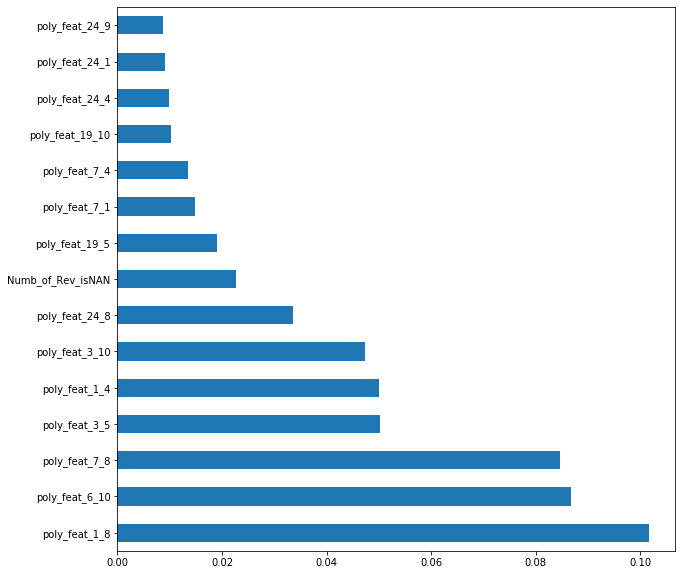

In [69]:
# Анализ: в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Для доработки:

1. Все вышепроведенные преобразования и функции можно записать в виде одной обрабатывающей функции, что более красиво для кода и позволяет тратить меньше времени при выборе фич.  
2. Можно перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

### Для проработки фичей созданы 2 функции

# 4.0 Submission

In [70]:
test_data.sample(10)

,Price Range,Rating,Numb_of_Rev_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,poly_feat_36_2,poly_feat_36_3,poly_feat_36_4,poly_feat_36_5,poly_feat_36_6,poly_feat_36_7,poly_feat_36_8,poly_feat_36_9,poly_feat_36_10,poly_feat_36_11
4652,3,0.0,0,0,0,0,0,0,0,0,...,-0.464456,-0.238639,-0.188564,-0.132580,-0.411072,-0.238639,-0.188564,-0.132419,-0.099070,-0.235263
9982,1,0.0,0,1,1,0,0,0,1,0,...,-0.688495,-0.238639,-0.188564,-0.132580,-0.479232,-0.238639,-0.188564,-0.132419,-0.099073,-0.248443
3593,3,0.0,0,0,0,0,0,0,0,0,...,-0.688495,-0.238639,-0.188564,-0.132598,-0.479232,-0.238639,-0.188564,-0.132419,-0.099076,-0.248443
5048,3,0.0,0,0,0,0,0,0,0,0,...,0.431698,-0.238639,-0.188564,-0.132455,0.134201,-0.238639,-0.188564,-0.132419,-0.098989,-0.024376
5090,2,0.0,0,0,0,0,0,1,0,0,...,-0.688495,-0.238639,-0.188564,-0.132584,-0.479232,-0.238639,-0.188564,-0.132419,-0.099074,-0.248443
493,1,0.0,0,1,1,0,0,0,0,0,...,-0.688495,-0.238639,-0.188564,-0.132598,-0.479232,-0.238639,-0.188564,-0.132419,-0.099076,-0.248443
4131,1,0.0,1,1,1,0,0,0,0,0,...,-0.688495,-0.238639,-0.188564,-0.132589,-0.479232,-0.238639,-0.188564,-0.132419,-0.099074,-0.248443
9091,2,0.0,0,0,0,1,0,0,0,0,...,-0.091058,-0.238639,-0.188564,-0.132525,-0.226069,-0.238639,-0.188564,-0.132419,-0.099042,-0.178148
5426,3,0.0,0,0,0,1,0,0,0,0,...,-0.091058,-0.238639,-0.188564,-0.132525,-0.226069,-0.238639,-0.188564,-0.132419,-0.099042,-0.178148
7046,3,0.0,0,0,0,0,0,0,0,0,...,-0.091058,-0.238639,-0.188564,-0.132575,-0.226069,-0.238639,-0.188564,-0.132419,-0.099064,-0.178148


In [71]:
test_data_1 = test_data.drop(['Rating'], axis=1)

In [72]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [73]:
model.predict(test_data_1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


array([3.155, 4.215, 4.255, ..., 2.97 , 4.49 , 4.22 ])

In [74]:
predict_submission = np.array(list(map(lambda x: round(x*2)/2, model.predict(test_data_1))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [75]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4. ])

In [76]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv(data_path+'submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.5
9,id_9,4.5
